In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.utils import plot_model
from pyvi import ViTokenizer
from pyvi import ViUtils

In [31]:
data = pd.read_csv("./data/vietnamese-comment-sentiment.csv")
data.head()

,ID,Title,Content,BriefContent,URL,Published Date,Week,Keyword,Group,Sub,Keyword 2,Sentiment,Ngành,Source,Channel,Author
0,1,- NĐTNN mua ròng trở lại trên sàn HOSE về m...,- NĐTNN mua ròng trở lại trên sàn HOSE về m...,"Bên cạnh đó các mã BCs lớn như VCB, GAS, VNM, ...",https://facebook.com/317106295063212/posts/759...,2015-01-12,W03 12/01-18/01,Vinamilk,Thương hiệu VNM,Chứng khoán,Vinamilk,Trung lập,NaN,facebook.com,Facebook,Lục Đục Lục Đục
1,2,- NĐTNN mua ròng trở lại trên sàn HOSE về m...,- NĐTNN mua ròng trở lại trên sàn HOSE về m...,"Bên cạnh đó các mã BCs lớn như VCB, GAS, VNM, ...",https://facebook.com/417567548348960/posts/634...,2015-01-12,W03 12/01-18/01,Vinamilk,Thương hiệu VNM,Chứng khoán,Vinamilk,Trung lập,NaN,facebook.com,Facebook,Lục Đục Lục Đục
2,3,- NĐTNN mua ròng trở lại trên sàn HOSE về m...,- NĐTNN mua ròng trở lại trên sàn HOSE về m...,"Bên cạnh đó các mã BCs lớn như VCB, GAS, VNM, ...",https://facebook.com/207745616086696/posts/324...,2015-01-12,W03 12/01-18/01,Vinamilk,Thương hiệu VNM,Chứng khoán,Vinamilk,Trung lập,NaN,facebook.com,Facebook,Lục Đục Lục Đục
3,4,- NĐTNN mua ròng trở lại trên sàn HOSE về m...,- NĐTNN mua ròng trở lại trên sàn HOSE về m...,"Bên cạnh đó các mã BCs lớn như VCB, GAS, VNM, ...",https://facebook.com/134153173367827/posts/688...,2015-01-12,W03 12/01-18/01,Vinamilk,Thương hiệu VNM,Chứng khoán,Vinamilk,Trung lập,NaN,facebook.com,Facebook,Lục Đục Lục Đục
4,5,"(----- SHARES -----) - Powerpoint : "" Sản ph...","(----- SHARES -----) - Powerpoint : "" Sản ph...",Sản phẩm vinamilk Probi,https://facebook.com/18303314136/posts/1015298...,2015-01-04,W01 01/01-04/01,Vinamilk,Sữa chua VNM,Thông tin chung,Vinamilk,Trung lập,Sữa chua,facebook.com,Facebook,Bảo Nguyễn


# Create Input + Label from raw data

In [32]:
# Create a new DataFrame with 'input' and 'label' columns
sentiment_data = pd.DataFrame({'input': data['BriefContent'], 'label': data['Sentiment']})

# Drop rows with missing values
sentiment_data = sentiment_data.dropna()

# Reset index
sentiment_data = sentiment_data.reset_index(drop=True)

# Display the first few rows of the DataFrame
sentiment_data.head()

,input,label
0,"Bên cạnh đó các mã BCs lớn như VCB, GAS, VNM, ...",Trung lập
1,"Bên cạnh đó các mã BCs lớn như VCB, GAS, VNM, ...",Trung lập
2,"Bên cạnh đó các mã BCs lớn như VCB, GAS, VNM, ...",Trung lập
3,"Bên cạnh đó các mã BCs lớn như VCB, GAS, VNM, ...",Trung lập
4,Sản phẩm vinamilk Probi,Trung lập


# PreProcessing Data and Prepare data for training

In [33]:
# Input data
input_data = sentiment_data['input'].values
input_label = sentiment_data['label'].values

# Label dictionary
label_dict = {"Tiêu cực": 0, "Trung lập": 1, "Tích cực": 2}

# Preprocessing data
input_pre = []
label_with_accent = []

for idx, dt in enumerate(input_data):
    # Preprocess input text
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)

    # Append processed input and label
    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)
    label_with_accent.append(input_label[idx])
    label_with_accent.append(input_label[idx])

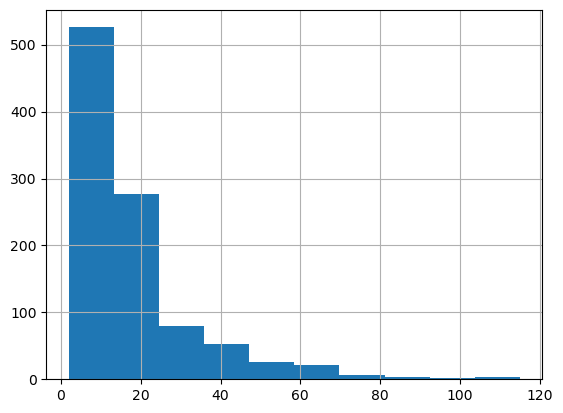

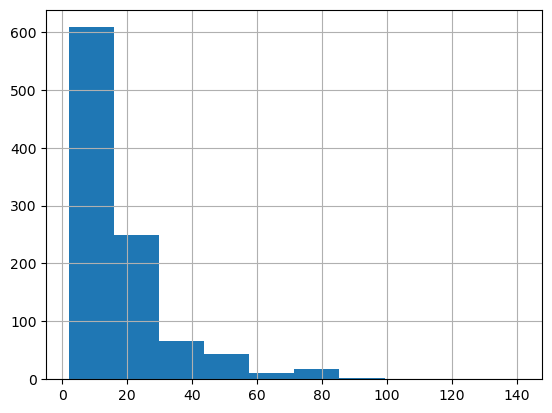

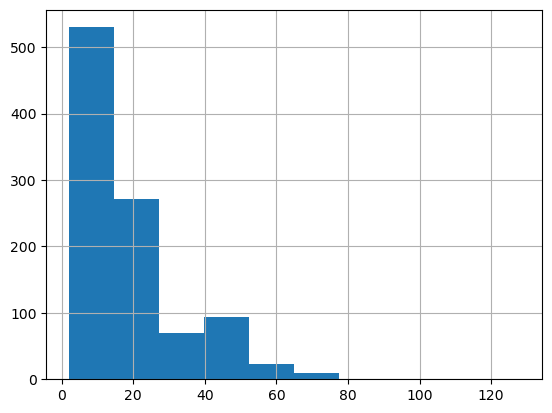

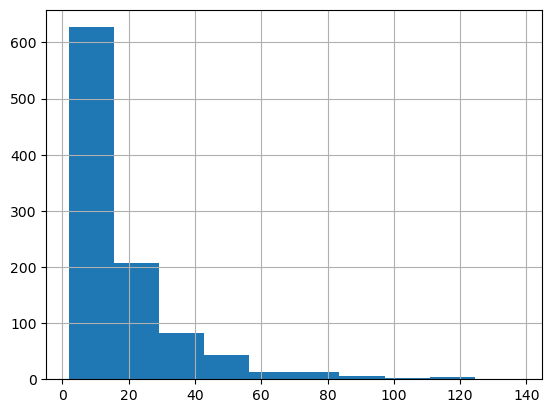

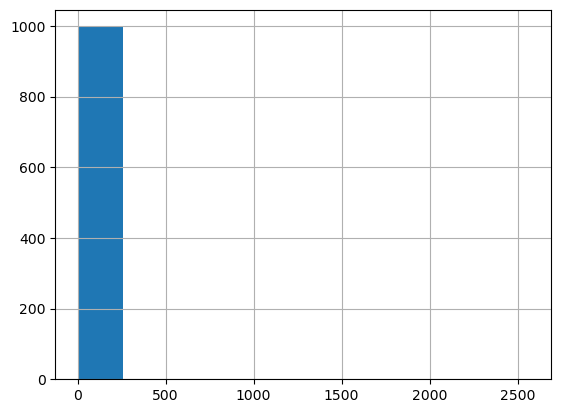

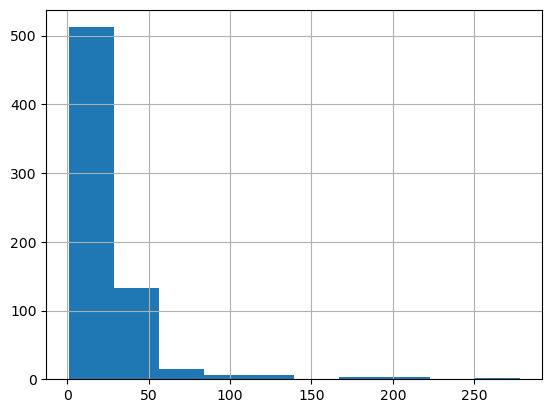

In [34]:
seq_len = [len(i.split()) for i in input_pre[0:1000]]
pd.Series(seq_len).hist(bins=10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[1000:2000]]
pd.Series(seq_len).hist(bins=10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[2000:3000]]
pd.Series(seq_len).hist(bins=10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[3000:4000]]
pd.Series(seq_len).hist(bins=10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[4000:5000]]
pd.Series(seq_len).hist(bins=10)
plt.show()

seq_len = [len(i.split()) for i in input_pre[5000:6500]]
pd.Series(seq_len).hist(bins=10)
plt.show()


In [35]:
label_idx = [label_dict[i] for i in label_with_accent]
#label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=num_classes)
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=3) # type: ignore


tokenizer_data = Tokenizer(oov_token='<OOV>', filters=' ', split=' ')
tokenizer_data.fit_on_texts(input_pre)

tokenized_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=512)

pickle.dump(tokenizer_data, open("tokenizer_data.pkl", "wb"))
print("input data.shape ", vec_data.shape)

data_vocab_size = len(tokenizer_data.word_index) + 1
print("data_vocab_size:", data_vocab_size)

X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("training sample:", len(X_train))
print("validation sample: ", len(X_val))
print("test sample: ", len(X_test))

input data.shape  (5682, 512)
data_vocab_size: 6527
training sample: 4090
validation sample:  1137
test sample:  455


# Create Model from Scratch

In [36]:
def generate_model():
    dropout_threshold = 0.4
    input_dim = data_vocab_size  # Thay thế bằng kích thước từ vựng thực tế của bạn
    output_dim = 32
    input_length = 512
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, embeddings_initializer="GlorotNormal")(input_layer)

    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature)
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer))(cnn_feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

    bi_lstm_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer='he_uniform'))(bi_lstm_feature)  # Sửa lại biến từ 'embedding_layer' thành 'bi_lstm_feature'
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    # Kết hợp các đặc trưng
    cnn_feature_pooled = GlobalMaxPooling1D()(cnn_feature)  # Áp dụng pooling
    bi_lstm_feature_pooled = GlobalMaxPooling1D()(bi_lstm_feature)  # Áp dụng pooling

    combine_feature = tf.keras.layers.Concatenate()([cnn_feature_pooled, bi_lstm_feature_pooled])
    combine_feature = LayerNormalization()(combine_feature)

    # Lớp phân loại
    classifier = Dense(90, activation='relu')(combine_feature)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(70, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(50, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(12, activation='softmax')(classifier)

    model = tf.keras.Model(inputs=input_layer, outputs=classifier)

    return model

model = generate_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 512, 32)   │    208,864 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 512, 32)   │      3,104 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 256, 32)   │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256, 32)   │          0 │ max_pooling1d_8[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 32)   │      3,104 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 128, 32)   │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 32)   │         64 │ max_pooling1d_9[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128, 32)   │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 128, 64)   │     16,640 │ dropout_11[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 64, 64)    │          0 │ bidirectional_4[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 64, 64)    │     18,816 │ max_pooling1d_10… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 32, 64)    │          0 │ bidirectional_5[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64)    │        128 │ max_pooling1d_11… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ dropout_11[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 96)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 270,174 (1.03 MB)

 Trainable params: 270,174 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#pip install pydot
#!pip install graphviz

#!pip install pydotplus
#!pip install --upgrade keras


# Visualize model Architecture

In [38]:
dot_img_file = 'model_visualize.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [ ]:
#callback_model = tf.keras.callbacks.ModelCheckpoint(filepath='model_con_bilstm.h5', monitor='val_loss')
#history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs = 10, batch_size = 128, callbacks=[callback_model])


callback_model = tf.keras.callbacks.ModelCheckpoint('model_google_embedding.keras', monitor='val_loss')
history = model.fit(
    x=X_train, y=y_train,
    epochs=50,
    validation_data=(X_val, y_val), callbacks=[callback_model]
)


Epoch 1/50


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 3), output.shape=(None, 12)

In [ ]:
model.save("model_cnn_bilstm.keras")  # Lưu model với định dạng .keras


In [ ]:
# In ra thư mục làm việc hiện tại
print("Current working directory:", os.getcwd())

# In ra danh sách các file trong thư mục hiện tại
print("Files in current directory:", os.listdir())


Current working directory: c:\MiMi\HK1 2024-2025\Sentiment Analysis
Files in current directory: ['data', 'model_cnn_bilstm.keras', 'model_google_embedding.keras', 'Note.txt', 'SentimentAnalysis.ipynb', 'tokenizer_data.pkl']


# Model Evaluation On Test Data

In [ ]:
# Load weights từ file
model.load_weights("model_cnn_bilstm.keras")  # Hoặc đường dẫn đầy đủ nếu cần
# Đánh giá model trên tập test
model.evaluate(X_test, y_test)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8578 - loss: 0.9652


[1.0336873531341553, 0.8505494594573975]

# Inference model with input test

In [ ]:
def preprocess_raw_input(raw_input, tokenizer):
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    print("Text preprocessed:", input_text_pre_accent)

    tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = tf.keras.preprocessing.sequence.pad_sequences(tokenized_data_text, padding='post', maxlen=512)
    return vec_data

def inference_model(input_feature, model):
    output = model(input_feature).numpy()[0]
    result = output.argmax()
    conf = float(output.max())
    label_dict = {'Tiêu cực': 0, 'Trung lập': 1, 'Tích cực': 2}
    label = list(label_dict.keys())
    return label[int(result)], conf

def prediction(raw_input, tokenizer, model):
    input_model = preprocess_raw_input(raw_input, tokenizer)
    result, conf = inference_model(input_model, model)
    return result, conf

# Assuming generate_model() is defined elsewhere
my_model = generate_model()
my_model.load_weights("model_cnn_bilstm.keras")

with open(r"tokenizer_data.pkl", "rb") as input_file:
    my_tokenizer = pickle.load(input_file)

print(prediction("sữa chua ngon lắm", my_tokenizer, my_model))

Text preprocessed: sữa_chua ngon lắm
('Tích cực', 0.9999221563339233)


In [ ]:
while(True):
    text = input("Nhập văn bản (hoặc gõ 'end' để thoát): ")
    if text == "end":
        break
    else:
        result = prediction(text, my_tokenizer, my_model)

        # Kiểm tra nếu `result` không rỗng
        if result and len(result) > 0:
            print(result[0] + "\n")
        else:
            print("Không có dự đoán nào. Vui lòng thử lại với văn bản khác.\n")


Text preprocessed: vinamilk được bình_chọn thương_hiệu ' tin và dùng '
Tích cực

